<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

from PIL import Image

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 150

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [4]:
!kaggle datasets download -d balalexv/fruits-vegetables-photos
with zipfile.ZipFile('/content/fruits-vegetables-photos.zip', 'r') as zip_obj:
   zip_obj.extractall('/content/')
!rm '/content/fruits-vegetables-photos.zip'

100% 1.79G/1.80G [00:25<00:00, 88.3MB/s]
100% 1.80G/1.80G [00:26<00:00, 74.2MB/s]


In [0]:
#shutil.rmtree('fruits_vegetables')

In [5]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)

for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  cnt_all = 0
  cnt_v = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cnt_all += 1
    if (np.random.randint(1, 11) == 1):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))
      cnt_v += 1
  print(f'{class_name}: VAL = {cnt_v}, ALL = {cnt_all}, PRC = {(cnt_v / cnt_all * 100):.4}')

grapefruit_yellow: VAL = 20, ALL = 202, PRC = 9.901
grape_black: VAL = 19, ALL = 218, PRC = 8.716
cucumber_prickly: VAL = 64, ALL = 611, PRC = 10.47
sultana: VAL = 52, ALL = 549, PRC = 9.472
pepper_red: VAL = 14, ALL = 128, PRC = 10.94
gala: VAL = 35, ALL = 274, PRC = 12.77
pepper_yellow: VAL = 18, ALL = 174, PRC = 10.34
bananas: VAL = 69, ALL = 644, PRC = 10.71
lady_fingers: VAL = 14, ALL = 179, PRC = 7.821
granny_smith: VAL = 51, ALL = 439, PRC = 11.62
tomato_plum: VAL = 74, ALL = 555, PRC = 13.33
lemon: VAL = 65, ALL = 588, PRC = 11.05
golden: VAL = 23, ALL = 227, PRC = 10.13


In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    #transforms.RandomPerspective(),
    #transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(0.5,0.5,0.5),
    #transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0)),
    transforms.Resize(IMG_SIZE),
    #transforms.CenterCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


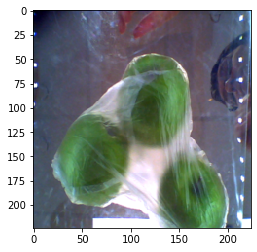

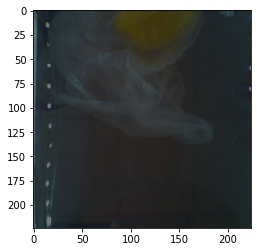

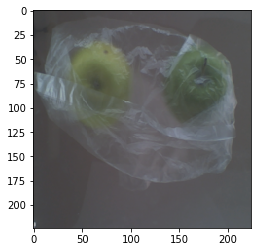

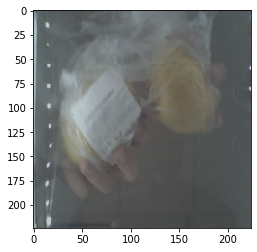

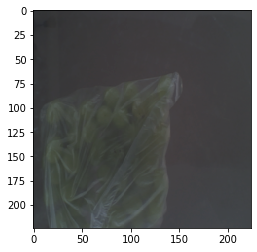

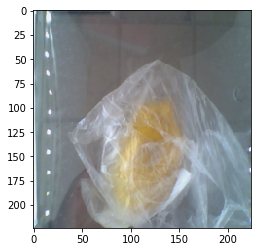

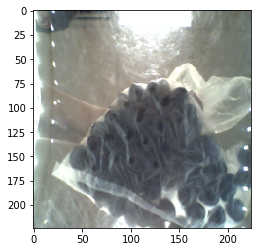

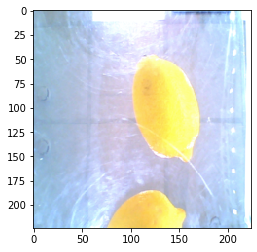

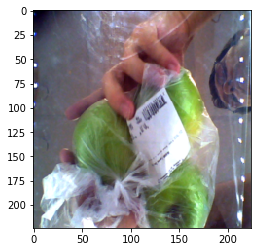

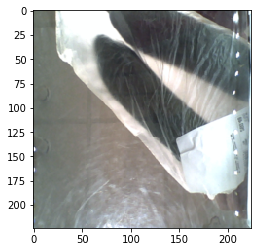

In [9]:
i = 0
n = 10

for inputs, labels in train_dataloader:
  for img in inputs:
    show_input(img)
    i += 1
    if i >= n:
      break
  if i >= n:
    break



In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  hist_loss_train = []
  hist_acc_train = []
  hist_loss_val = []
  hist_acc_val = []
  for epoch in range(num_epochs):
    # Train
    running_loss = 0.
    running_acc = 0.
    model.train()
    #for inputs, labels in tqdm(train_dataloader):
    for inputs, labels in train_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
    loss_train = running_loss / len(train_dataloader)
    acc_train = running_acc / len(train_dataloader)
    scheduler.step(loss_train)
    # Val
    running_loss = 0.
    running_acc = 0.
    model.eval()
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
    loss_val = running_loss / len(val_dataloader)
    acc_val = running_acc / len(val_dataloader)
    
    print(f'Epoch {epoch}/{num_epochs - 1}: Train: Loss: {loss_train:.4f}, Acc: {acc_train:.4f}   Val: Loss: {loss_val:.4f}, Acc: {acc_val:.4f}', flush=True)
    hist_loss_train.append(loss_train)
    hist_acc_train.append(acc_train.item())
    hist_loss_val.append(loss_val)
    hist_acc_val.append(acc_val.item())

  return model, [hist_loss_train,hist_acc_train,hist_loss_val,hist_acc_val]

In [0]:
cl_cnt = {}
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  cl_cnt[class_name] = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cl_cnt[class_name] += 1

In [12]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

#model.fc = torch.nn.Sequential(
#    torch.nn.Linear(model.fc.in_features, 512),
#    torch.nn.ReLU(),
#    torch.nn.Dropout(0.4),
#    torch.nn.Linear(512, len(train_dataset.classes))
#    , torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
#)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(weight=cl_weight.float())
#loss = torch.nn.NLLLoss(weight=cl_weight.float())

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2, weight_decay = 0.05, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=5, threshold= 0.001, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 252MB/s]


In [13]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=3);

Epoch 0/2: Train: Loss: 4.3378, Acc: 0.3732   Val: Loss: 0.7429, Acc: 0.8033
Epoch 1/2: Train: Loss: 0.5699, Acc: 0.8332   Val: Loss: 0.2614, Acc: 0.9106
Epoch 2/2: Train: Loss: 0.3437, Acc: 0.9102   Val: Loss: 0.2799, Acc: 0.9426


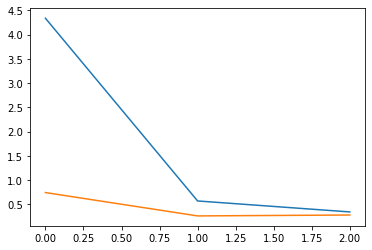

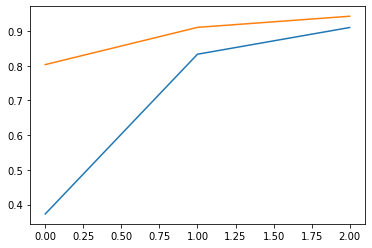

In [14]:
plt.plot(hist[0][0:])
plt.plot(hist[2][0:])
plt.show()

plt.plot(hist[1][0:])
plt.plot(hist[3][0:])
plt.show()


In [0]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=117, shuffle=False, num_workers=8)

In [16]:
model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()

print(running_acc.item() / 117, 117 - running_acc.item())

0.7264957264957265 32.0


In [0]:
for i in range(inputs.size()[0]):
  if (preds_class[i] != labels.data[i]):
    show_input(inputs[i].cpu(), train_dataset.classes[preds_class[i]])


In [196]:
(224 -56) // 50

3

In [53]:
!nvidia-smi

Tue Jan 28 14:08:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |   2763MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [230]:
len_row

5

In [0]:
img = inputs[0]
img = img.view([1,3,224,224])

class_id = 0
size_square = 56
size_step = 70
len_row = img.size()[2] // size_step + 1
len_col = img.size()[3] // size_step + 1


imgs = torch.cat([img for i in range(len_row * len_col)])


for i in range(len_row):
  for j in range(len_col):
    imgs[i* len_row + j, :, i*size_step:i*size_step+size_square , j*size_step:j*size_step+size_square] *= 0


In [52]:
imgs.size()

torch.Size([16, 3, 224, 224])

In [0]:
for img_t in imgs:
  show_input(img_t.cpu())


In [0]:
new_img = torch.zeros(224,224)


In [48]:
for s in torch.nn.functional.softmax(model(imgs).data ,dim=1)[:,class_id]:
  print(s.item())


0.7965353727340698
0.8981321454048157
0.8869742751121521
0.8800995349884033
0.8159273862838745
0.9305902719497681
0.7678123116493225
0.868619978427887
0.8273888826370239
0.9118935465812683
0.8828726410865784
0.8825846910476685
0.8847594857215881
0.9198592901229858
0.9263745546340942
0.8702853322029114


In [33]:
torch.ones(size_square, size_square).cuda() * torch.nn.functional.softmax(model(imgs).data ,dim=1)[0,class_id]

tensor([[0.7965, 0.7965, 0.7965,  ..., 0.7965, 0.7965, 0.7965],
        [0.7965, 0.7965, 0.7965,  ..., 0.7965, 0.7965, 0.7965],
        [0.7965, 0.7965, 0.7965,  ..., 0.7965, 0.7965, 0.7965],
        ...,
        [0.7965, 0.7965, 0.7965,  ..., 0.7965, 0.7965, 0.7965],
        [0.7965, 0.7965, 0.7965,  ..., 0.7965, 0.7965, 0.7965],
        [0.7965, 0.7965, 0.7965,  ..., 0.7965, 0.7965, 0.7965]],
       device='cuda:0')